# Implementing Shor's algorithm

Here, we are only interested in the part of the algorithm solving the period-finding function.


## To hand out

1. A **report** with your answers in a **PDF FILE** (made out of LaTeX, libreoffice, ...)
  * Math and text answers
  * The code for the circuits
  * Screenshot of figures/circuits
  * python answers and results of runs
  * *etc*
  
2. **This notebook**
  * as a runnable script



But first, some libraries to load (nothing to modify here)

In [1]:
import numpy as np
from math import pi, gcd
try:
    from qiskit import *
    from matplotlib.pyplot import plot,show
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from scipy import optimize
from matplotlib.pyplot import plot,show,savefig
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

## A few useful functions

- `nat2bl` : from a natural number to a list of `0` and `1` (low-end bit on the right)
- `nat2bs` : from a natural number to a string such as `"010010011"`
- `bl2bs` : from a list to a string
- ... and all of the functions in the other direction.

In [2]:
def nat2bl(pad,n):
    if n == 0 :
        return [0 for i in range(pad)]
    elif n % 2 == 1:
        r = nat2bl(pad-1,(n-1)//2)
        r.append(1)
        return r
    else:
        r = nat2bl(pad-1,n//2)
        r.append(0)
        return r

for i in range(16):
    print(nat2bl(5,i))

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]


In [3]:
def bl2nat(s):
    if len(s) == 0:
        return 0
    else:
        a = s.pop()
        return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0:
        return ""
    else:
        a = l.pop()
        return (bl2bs(l) + str(a))

def nat2bs(pad,i):
    return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)):
        l.append(int(s[i]))
    return l

def bs2nat(s):
    return bl2nat(bs2bl(s))


print(nat2bs(10,17))
print(bs2nat("0011010"))

0000010001
26


# 0 - Before anything else...

### Make sure you have done Part 1 on QPE


# 1 - Introduction

In this lab session we are going to code the heart of Shor's algorithm: the circuit making it possible to find the period of the function

$$
x \mapsto a^x mod N.
$$

We first need to code the oracle computing the multiplication modulo, then to combined it with QPE.

**Objective** : Only to convince yourself that the number we are looking for can be recovered from the final distribution.

**Prerequisite** : To have finished the Jupyter Notebook called `TP-QPE`

Let's go.

# 2 - Oracle synthesis

The function $f : x\mapsto (a^p\cdot x)~mod~N$ is a bijection of $\{0...N-1\}$ to $\{0...N-1\}$ if $a$ and $N$ are co-primes. 

In this case, we can consider $f$ as a unitary operator acting on a Hilbert space of dimension $N$.
One can then consider $f$ as a unitary acting on a register of qubits, provided that $N$ is a power of $2$.

This is a bit limited : we want to be able to consider arbitrary numbers $N$. We then instead consider the function:
$$
Mult_{a^p~mod~N} : x\mapsto 
\left\{
\begin{array}{ll}
(a^p\cdot x)~mod~N & \text{si }x < N
\\
x & \text{si} N \leq x < 2^n
\end{array}\right.
$$
provided that $N<2^n$.

This new function $Mult_{a^p~mod~N}$ is indeed a bijection of $\{0..2^n\}$: we are going to implement this one instead. Here, we are making something simple, using the automated circuit synthesis of QisKit. It is not the most efficient, but it is the easiest for our purpose.

To clarify what is expected, let us consider the code for $Mult_{2^3~mod~13}$, that is, $Mult_{8~mod~13}$. To store all of the numbers from $0$ to $12$ we need $4$ bits. The table for the operation $Mult_{8~mod~13}$ is as follows. We first write it using decimal numbers, then with the binary decomposition. Note how starting from $x=13$ we are just padding to complete to $15 = 2^4-1$.


| x  |  result  | | x (binary) | result (binary) |
|:--:|:--------:|-|:----------:|:---------------:|
| 0  |  0       | | 0000       | 0000            |
| 1  |  8       | | 0001       | 1000            |
| 2  |  3       | | 0010       | 0011            |
| 3  |  11      | | 0011       | 1011            |
| 4  |  6       | | 0100       | 0110            |
| 5  |  1       | | 0101       | 0001            |
| 6  |  9       | | 0110       | 1001            |
| 7  |  4       | | 0111       | 0100            |
| 8  |  12      | | 1000       | 1100            |
| 9  |  7       | | 1001       | 0111            |
| 10 |  2       | | 1010       | 0010            |
| 11 |  10      | | 1011       | 1010            |
| 12 |  5       | | 1100       | 0101            |
| -- | --       | | ----       | ----            |
| 13 | 13       | | 1101       | 1101            |
| 14 | 14       | | 1110       | 1110            |
| 15 | 15       | | 1111       | 1111            |

The corresponding matrix is then

$$
\begin{array}{ccccccccccccc|ccc}
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\\hline
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{array}
$$

The top-left block corresponds to the permutation matrix : $|0010\rangle$ is for instance sent to $|0011\rangle$ (i.e. $2$ is sent to $3$). The bottom-right block corresponds to the padding with identity, to build an unitary matrix defined on the whole space.


## Questions

### Q 2.1 Operator for the multiplication modulo.

- Complete the following code so that `M` is a matrix implementing the bijection $Mult_{a^p~mod~N}$.
- Test it with the code below it, with $a = 1, 3, 6, 11, 15$.

In [4]:
# a, p, N et n are as above
# we compute x |--> a^p * x mod N, seen as an operator on C^{2^n}

def gateMult(a,p,N,n):
    nn = 2 ** n
    M = [[0 for x in range(nn)] for i in range(nn)]
    for x in range(nn):
        if x < N:
            M[((a**p)*x) % N][x] = 1
        else:
            M[x][x] = 1
    U = Operator(M)
    return(UnitaryGate(U))

In [5]:
# Code to test the circuit computing (x * a ^ p) mod N, on n qubits

# VALUES TO POSSIBLY CHANGE
# BEWARE to keep x and N < 2^n
x = 3
a = 2
p = 4
N = 11
n = 4

# TEST TO NOT CHANGE

phi = QuantumRegister(n)
cphi = ClassicalRegister(n)

qc = QuantumCircuit(phi,cphi)
vl = nat2bl(n,x)
print(f"Input : {str(vl)} (= {x} en décimal)")
vl.reverse() # Changement de la place du bit de poid faible
for i in range(len(vl)):
    if vl[i] == 1:
        qc.x(phi[i])

qc.append(gateMult(a,p,N,n),list(phi))
qc.measure(phi,cphi)

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)

assert(len(d) == 1)
s =  list(d.keys())[0]

if x < 11:
    print(f"Correct answer should be {x} * {a}^{p} mod {N} = {(x*(a ** p)) % N}")
else:
    print(f"We are above {N} so this should be the identity")
print(f"The circuit answer: {s} (= {bs2nat(s)} in decimal)")

# If you run it, it should print a log of what is expected and what is indeed computed.

Input : [0, 0, 1, 1] (= 3 en décimal)
Correct answer should be 3 * 2^4 mod 11 = 4
The circuit answer: 0100 (= 4 in decimal)


### Q 2.2 Size of generated circuit

Qiskit packages the circuit it makes out of the matrix inside a nice and clean box. What is the concrete size of the generated circuit ? Let us test it to see.

- TODO : modify the code below to compute the size of the circuits generated by QisKit for the following matrices:
  * `gateMult(3,3,2 ** 2,2)`
  * `gateMult(3,3,2 ** 3,3)`
  * `gateMult(3,3,2 ** 4,4)`

And if the runtime is not too daunting (stop if above 1 minute)

  * `gateMult(3,3,2 ** 5,5)`
  * `gateMult(3,3,2 ** 6,6)` 
  * `gateMult(3,3,2 ** 7,7)`
  
#### Report your code and answers in the separate report !

In [6]:
n = 3
q = QuantumRegister(n)

qc = QuantumCircuit(q)
#qc.h(q[0])
#qc.x(q[1])
#qc.ccx(q[0],q[1],q[2]) # a Toffoli gate, for the sake of it.

qc.append(gateMult(3,3,2**n,n), q)

pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc)

count = new_circ.count_ops()

In [7]:
r = 0
for k in count:
    r += count[k]
print(f"For {n} qubits there are {r} gates in total.")

For 3 qubits there are 61 gates in total.


### Q 2.3 Analysis

- What are the sizes of the generated circuits ?
- What is the complexity of the circuit size in term of number of qubits ?
- Can you explain why ?
- If it is doable for small `n`, is it realisitic for large sizes ?
- What alternate method could you suggest, with what potential drawbacks ?


#### Report your code and answers in the separate report !


# 3 - Plugging everything together : Shor

We are now ready to realize Shor's algorithm

## Questions

### Q 3.1 The circuit

Realize the circuit:
- Copy-paste the code of QPE, with 4 qbits of precision for `eig`
- Introduce our home-made unitary : choose 5 qbits pour `phi`
- Place `phi` in the state corresponding to the integer $1$ in decimal (beware of the position of the low-end bit)


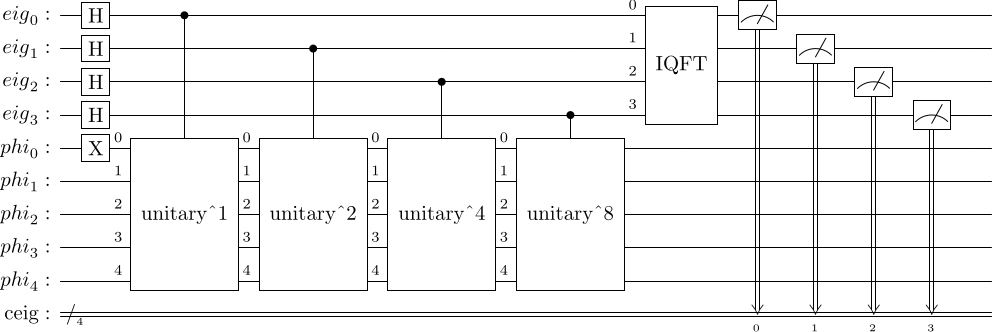

In [24]:
a = 10
N = 21
size_eig = 4
size_phi = 5

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)

qc.x(phi[0])
U = gateMult(a,a,N,5)
for i in range(0, size_eig):
    qc.h(eig[i])
    qc.append(U.power(2**i).control(), [eig[i]] + list(phi))

qc.append(QFT(size_eig).inverse(), eig)
qc.measure(eig, ceig)

qc.draw('latex')

In [25]:
# Then we can run things.

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100000)
d = job.result().get_counts(qc)
d

{'0101': 23031,
 '0000': 33557,
 '1100': 1563,
 '1011': 23074,
 '1001': 1141,
 '0110': 5812,
 '1010': 5896,
 '1000': 754,
 '0010': 361,
 '0111': 1195,
 '0100': 1536,
 '0001': 274,
 '1101': 629,
 '1111': 267,
 '0011': 558,
 '1110': 352}

### Q 3.2 Results

We get a distribution of résults in the form of a dictionary.
 - each key is morally a fraction $s/r$, for $r$ the order of $a$ mod $N$
 - it is only written with some precision (depending on the chosen number of bits), and it is written in binary.
 - The value associated to a key is the number of times we found the corresponding key.
 
Below is a code drawing a graph out of `d` with horizontal axis the key, in decimal, and in vertical axis the number of times we found it.

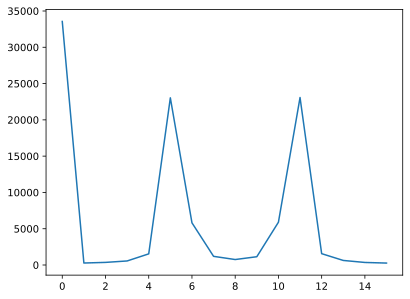

In [26]:
pts = []
for i in range(2**size_eig):
        k = nat2bs(size_eig,i)
        if k in d:
            pts.append((i,d[k]))
        else:
            pts.append((i,0))

def snd(a):
    (a1,a2) = a
    return a1
        
pts.sort(key = snd)

xs = []
ys = []
for i in range(len(pts)):
    (x,y) = pts[i]
    xs.append(x)
    ys.append(y)
plot(xs,ys)
savefig("rapport/plot2.png")

### Q 3.3 Analysis

- What is the order $r$ of $a$ mod $N$ (here $7$ mod $30$) ?
- On the drawing, where are we supposed to see the values $\frac{s}{r}$ ? The horizontal axis is graded with integers... To what real numbers between 0 and 1 these correspond to ?
- Can you infer from the graph the value of $r$ ? Where do you see it on the graph ?
- Change a and N respectively to 20 and 29. Can you read the value $r$ ? Is it correct ?
- The drawing is not very precise... How to make it better ? Try it !
- Is it still working if you change the value of `a` and/or `N` to other values ? Beware not to use too large values for`N`... To get some inspiration, below is the list of possibilities up to 31.

**BEWARE** Make sure to only consider coprimes `a` and `N`.

#### Report in the separate report:
* your code
* screenshots of circuits
* the results of your runs
* screenshots of plots 
* answers to questions and discussion


In [46]:
for N in range(3,32):
    for a in range(2,N):
        if gcd(a,N) == 1:
            for p in range(1,N):
                if (a ** p) % N == 1:
                    break
            print(f"Order of {a} mod {N}: {p}")

Order of 2 mod 3: 2
Order of 3 mod 4: 2
Order of 2 mod 5: 4
Order of 3 mod 5: 4
Order of 4 mod 5: 2
Order of 5 mod 6: 2
Order of 2 mod 7: 3
Order of 3 mod 7: 6
Order of 4 mod 7: 3
Order of 5 mod 7: 6
Order of 6 mod 7: 2
Order of 3 mod 8: 2
Order of 5 mod 8: 2
Order of 7 mod 8: 2
Order of 2 mod 9: 6
Order of 4 mod 9: 3
Order of 5 mod 9: 6
Order of 7 mod 9: 3
Order of 8 mod 9: 2
Order of 3 mod 10: 4
Order of 7 mod 10: 4
Order of 9 mod 10: 2
Order of 2 mod 11: 10
Order of 3 mod 11: 5
Order of 4 mod 11: 5
Order of 5 mod 11: 5
Order of 6 mod 11: 10
Order of 7 mod 11: 10
Order of 8 mod 11: 10
Order of 9 mod 11: 5
Order of 10 mod 11: 2
Order of 5 mod 12: 2
Order of 7 mod 12: 2
Order of 11 mod 12: 2
Order of 2 mod 13: 12
Order of 3 mod 13: 3
Order of 4 mod 13: 6
Order of 5 mod 13: 4
Order of 6 mod 13: 12
Order of 7 mod 13: 12
Order of 8 mod 13: 4
Order of 9 mod 13: 3
Order of 10 mod 13: 6
Order of 11 mod 13: 12
Order of 12 mod 13: 2
Order of 3 mod 14: 6
Order of 5 mod 14: 6
Order of 9 mod 14: 